# Downloading Dataset

In [29]:
import numpy as np
import matplotlib.pyplot as plt

import requests
import tarfile
import os
import pickle


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset



Download the CIFAR10
https://github.com/EN10/CIFAR/blob/master/load_cifar.py

Unzipping and extracting: https://stackoverflow.com/questions/12902540/read-a-gzip-file-in-python

In [30]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
response = requests.get(url)

with open("cifar-10-python.tar.gz", "wb") as file:
  file.write(response.content)

In [31]:
# unzip the dataset and take look what are the files
file_path = "cifar-10-python.tar.gz"

with tarfile.open(file_path, "r:gz") as tar:
  tar.extractall()
data_dir = "cifar-10-batches-py"
print(os.listdir(data_dir))


['data_batch_3', 'data_batch_1', 'data_batch_2', 'batches.meta', 'data_batch_5', 'readme.html', 'data_batch_4', 'test_batch']


In [32]:
# access a batch
def load_batch(file_path):
  with open(file_path, "rb") as f:
    # eencoing choose bytes eensuree reading
    data = pickle.load(f, encoding="bytes")
  return data

# use iterate load_batch to load all batches from the image dataset
def load_all_batches(data_dir):
  images = []
  labels = []
  for i in range(1, 6):  # Loop through data_batch_1 to data_batch_5
    batch = load_batch(os.path.join(data_dir, f"data_batch_{i}"))
    images.append(batch[b"data"])
    labels += batch[b"labels"]
  # concanate with vstack to wrap up all data_Batches
  return np.vstack(images), np.array(labels)

# subsample certain images from each classes
def subsample_classes(images, labels, per_classSamples=1000):
  # create a dictionary to keep each seprateely
  scene_category = {i: [] for i in range(10)}
  sampled_images = []
  sampled_labels = []

  # initialize catrgory dictonary
  for i in range(len(labels)):
    scene_category[labels[i]].append(images[i])

  for label, data in scene_category.items():
    # conveert to np, easier to select sub-indexes
    data = np.array(data)
    # random choice geenerate random indexs
    indices = np.random.choice(data.shape[0], per_classSamples, replace=False)
    sampled_images.append(data[indices])
    # fill with class samples and their label
    sampled_labels.append(np.full(per_classSamples, label))
  # stack up the training and target samples
  sampled_images = np.vstack(sampled_images)
  sampled_labels = np.concatenate(sampled_labels)
  # randomize the indexs the datasets to increase randomnss and reduce bias
  shuffled_indices = np.random.permutation(len(sampled_labels))
  return sampled_images[shuffled_indices], sampled_labels[shuffled_indices]


### Take look a sample of training datapoint from data_Batch_!


In [33]:
batch_path = os.path.join(data_dir, "data_batch_1")
batch_data = load_batch(batch_path)

print(batch_data.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [34]:
# test = batch_data[b"data"]
# print(test.shape)

b'data':

A NumPy array of shape (10000, 3072) where each row represents a 32x32 image flattened into a vector.

b'labels':

A list of 10,000 integers corresponding to the labels (0–9).

In [35]:
# Get the images and labels
# filenames = [b'filenames']
images = batch_data[b"data"]
labels = batch_data[b"labels"]



In [36]:
labels[0]

6

Loading and plotting CIFAR-10:

https://github.com/devyhia/cifar-10/blob/master/Load%20%26%20Visualize%20CIFAR-10.ipynb

https://stackoverflow.com/questions/35995999/why-cifar-10-images-are-not-displayed-properly-using-matplotlib

Here, you need to note that the image size for plt.imshow should be (awidth x height x RGB i.e. (32 x 32 x 3). The default is (3 x 32 x 32), that's why l use: .T (which is the transpose of 32 x 32 x 3 = 3 x 32 x 32).

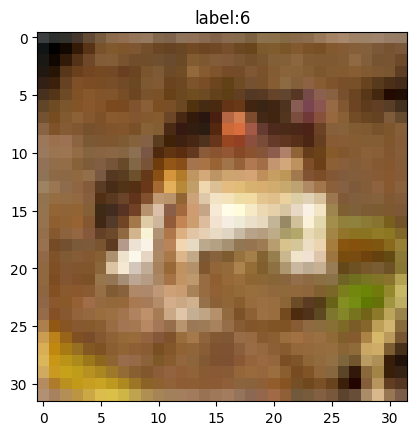

In [37]:
#image = images[0].reshape(32, 32, 3)
image = images[0].reshape(3, 32, 32).transpose(1, 2, 0)
plt.imshow(image)
plt.title("label:" + str(labels[0]))
plt.show()


### Next, load all 5 batch files's image and vstack them together
https://www.datascienceweekly.org/tutorials/normalize-cifar10-dataset-tensor

In [38]:
# Load training and test data
train_images, train_labels = load_all_batches(data_dir)
# access test batch file
test_batch = load_batch(os.path.join(data_dir, "test_batch"))

test_images = test_batch[b"data"]
test_labels = np.array(test_batch[b"labels"])

# the -1 in reshape to flatten images, do a transpose to align with pytorch expectation
train_images = train_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# normalize
train_images = train_images/255
test_images = test_images/255

# select a subsample contain 10000 images where 1000 images per class from orignal dataset
x_train_subset, y_train_subset = subsample_classes(train_images, train_labels, 1000)



In [39]:
# print(train_images.reshape(-1, 3, 32, 32).shape)
# print(train_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).shape)
# image = train_images[1]
# plt.imshow(image)
# plt.title(labels[1])
# plt.show()

# Data preparation and compability scale for pytorch
1. Data Preparation

In [40]:
# https://www.kaggle.com/code/fanbyprinciple/cifar10-explanation-with-pytorch
# use torch's tensor to train with pytorch resnet
# permutation for batch, channels, height, width
x_train_tensor = torch.tensor(x_train_subset, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_scalar = torch.tensor(y_train_subset)

x_test_tensor = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_scalar = torch.tensor(test_labels)

# create tensor datasets is compatie with pytorch expected format, combine both feature and target value in a row
train_dataset = TensorDataset(x_train_tensor, y_train_scalar)
test_dataset = TensorDataset(x_test_tensor, y_test_scalar)

# use a batch size to avoid computing similar datapints
train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)


In [41]:
# print("x_train_tensor shape: ", x_train_tensor.shape, "y_train_scalar shape: ",y_train_scalar.shape)
# print("x_test_tensor shape: ", x_test_tensor.shape, "y_test_scalar shape: ",y_test_scalar.shape)


In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Problem1, implment baseline Resnet18

https://www.geeksforgeeks.org/resnet18-from-scratch-using-pytorch/#
2. Model initializing

In [43]:
# select resNet18 from pytorch
model = models.resnet18(pretrained=False)
# fully connected, 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)
# use cross entropy as loss function
criterion = nn.CrossEntropyLoss()
# Adam to optimize the ggradient
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

3. Training Function

The structure is from
https://gist.github.com/MLWhiz/2cd4712647f72d4078caf4d76b650717

We will track the
1. train losses over epoch
2. train accuracies
3. validation loss
4. validation accuracy


In [45]:
def train_baseline(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cuda'):
  model.to(device)

  # save learning records
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for epoch in range(num_epochs):
    print(epoch + 1,"th epoch out of ", num_epochs)
    model.train()

    running_loss = 0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(train_loader):
      inputs, targets = inputs.to(device), targets.to(device)

      # forward pass
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # backward pass and Adam optimizing
      loss.backward()
      optimizer.step()

      # record loss
      running_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += targets.size(0)
      correct += (predicted == targets).sum().item()

    # track progress
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # evaluate on validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
      for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # record loss
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_total += targets.size(0)
        val_correct += (predicted == targets).sum().item()

    # track progress
    val_loss /= len(test_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}, \tTrain Loss: {train_loss:.4f}, \tTrain Acc: {train_accuracy:.2f}%, \tVal Loss: {val_loss:.4f}, \tVal Acc: {val_accuracy:.2f}%\n")
  return train_losses, train_accuracies, val_losses, val_accuracies


4. Train the Model

In [46]:
train_losses, train_accuracies, val_losses, val_accuracies = train_baseline(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=10,
    device=device
)


1 th epoch out of  10
Epoch 1, 	Train Loss: 1.7608, 	Train Acc: 35.92%, 	Val Loss: 1.5743, 	Val Acc: 42.89%

2 th epoch out of  10
Epoch 2, 	Train Loss: 1.3783, 	Train Acc: 50.23%, 	Val Loss: 1.6678, 	Val Acc: 42.74%

3 th epoch out of  10
Epoch 3, 	Train Loss: 1.1680, 	Train Acc: 58.53%, 	Val Loss: 1.6234, 	Val Acc: 43.84%

4 th epoch out of  10
Epoch 4, 	Train Loss: 1.0041, 	Train Acc: 63.91%, 	Val Loss: 1.6598, 	Val Acc: 45.94%

5 th epoch out of  10
Epoch 5, 	Train Loss: 0.8879, 	Train Acc: 67.95%, 	Val Loss: 1.8221, 	Val Acc: 45.97%

6 th epoch out of  10
Epoch 6, 	Train Loss: 0.7703, 	Train Acc: 72.82%, 	Val Loss: 1.6161, 	Val Acc: 50.88%

7 th epoch out of  10
Epoch 7, 	Train Loss: 0.6555, 	Train Acc: 76.64%, 	Val Loss: 1.7967, 	Val Acc: 46.56%

8 th epoch out of  10
Epoch 8, 	Train Loss: 0.5577, 	Train Acc: 80.02%, 	Val Loss: 1.9085, 	Val Acc: 46.78%

9 th epoch out of  10
Epoch 9, 	Train Loss: 0.4808, 	Train Acc: 82.86%, 	Val Loss: 2.2805, 	Val Acc: 47.16%

10 th epoch out of 

5. Plot learning curves

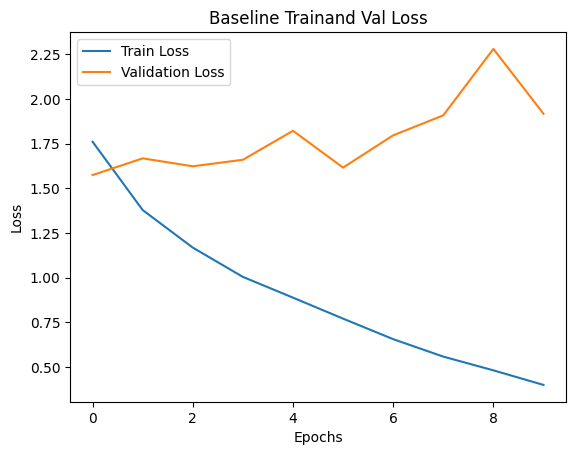

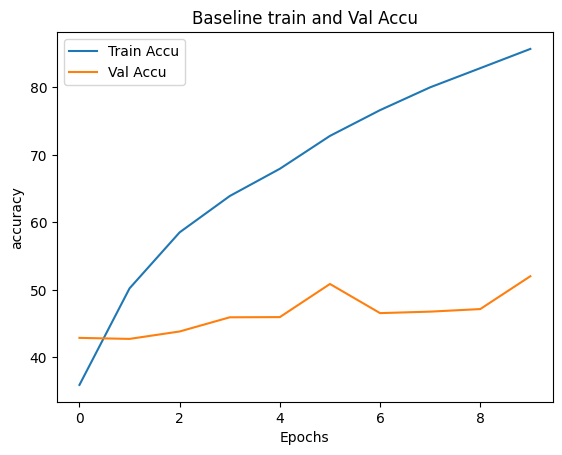

In [47]:
# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Baseline Trainand Val Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accuracies, label='Train Accu')
plt.plot(val_accuracies, label='Val Accu')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Baseline train and Val Accu')
plt.legend()
plt.show()


# problem2 Mixup

Mixup generates new training examples by linearly interpolating between two randomly chosen examples from the dataset. It operates on both the input images and their corresponding labels.

Mixup and cutout in practical https://www.kaggle.com/code/kaushal2896/data-augmentation-tutorial-basic-cutout-mixup

1. Data Preparation

In [48]:
# Convert scalar labels to one-hot encoded labels for Mixup
def to_one_hot(labels, classes=10):
  one_hot = torch.nn.functional.one_hot(labels, num_classes=classes)
  return one_hot.float()

y_train_one_hot = to_one_hot(torch.tensor(y_train_subset))
y_test_one_hot = to_one_hot(torch.tensor(test_labels))

# Create PyTorch datasets
train_dataset = TensorDataset(x_train_tensor, y_train_one_hot)
test_dataset = TensorDataset(x_test_tensor, y_test_one_hot)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)


In [49]:
print("x_train_tensor shape: ", x_train_tensor.shape, "y_train_scalar shape: ",y_train_scalar.shape)
print("x_test_tensor shape: ", x_test_tensor.shape, "y_test_scalar shape: ",y_test_scalar.shape)

x_train_tensor shape:  torch.Size([10000, 3, 32, 32]) y_train_scalar shape:  torch.Size([10000])
x_test_tensor shape:  torch.Size([10000, 3, 32, 32]) y_test_scalar shape:  torch.Size([10000])


2. Model Definition

Restart the resnet18 from fresh. No pretraining. re-specifiy the optimizer

In [50]:
# select resNet18 from pytorch
model = models.resnet18(pretrained=False)
# fully connected, 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
# use cross entropy as loss function
criterion = nn.CrossEntropyLoss()
# Adam to optimize the ggradient
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

3. Define Mixup Function
https://github.com/hongyi-zhang/mixup/blob/master/cifar/utils.py

In [51]:
def mixup_data(x, y, alpha=0.2):
  if alpha > 0.:
        Mixing_lambda = np.random.beta(alpha, alpha)
  else:
        Mixing_lambda = 1.

  batch_size = x.size(0)
  index = torch.randperm(batch_size)

  mixed_x = Mixing_lambda * x + (1 - Mixing_lambda) * x[index, :]
  mixed_y = Mixing_lambda * y + (1 - Mixing_lambda) * y[index, :]
  return mixed_x, mixed_y


4. Training Function

In [52]:
def train_with_mixup(model, train_loader, test_loader, criterion, optimizer, alpha=0.2, num_epochs=10, device='cuda'):
  model.to(device)

  # save learning records
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for epoch in range(num_epochs):
    print(epoch + 1,"th epoch out of ", num_epochs)
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(train_loader):
      inputs, targets = inputs.to(device), targets.to(device)

      # Mixup
      mixed_inputs, mixed_targets = mixup_data(inputs, targets, alpha)
      mixed_inputs, mixed_targets = mixed_inputs.to(device), mixed_targets.to(device)

      # forward pass
      optimizer.zero_grad()
      outputs = model(mixed_inputs)
      loss = criterion(outputs, torch.argmax(mixed_targets, dim=1))

      # backward pass and Adam optimizing
      loss.backward()
      optimizer.step()

      # record loss
      running_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += targets.size(0)
      correct += (predicted == torch.argmax(targets, dim=1)).sum().item()

    # track progress
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # evaluate on validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
      for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(targets, dim=1))

        # record loss
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_total += targets.size(0)
        val_correct += (predicted == torch.argmax(targets, dim=1)).sum().item()

    # track progress
    val_loss /= len(test_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}, \tTrain Loss: {train_loss:.4f}, \tTrain Acc: {train_accuracy:.2f}%, \tVal Loss: {val_loss:.4f}, \tVal Acc: {val_accuracy:.2f}%\n")

  return train_losses, train_accuracies, val_losses, val_accuracies


5. Train the Model with alpha = 0.2

In [53]:
train_losses, train_accuracies, val_losses, val_accuracies = train_with_mixup(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    alpha=0.2,
    num_epochs=10,
    device=device
)


1 th epoch out of  10
Epoch 1, 	Train Loss: 1.8053, 	Train Acc: 24.29%, 	Val Loss: 1.8081, 	Val Acc: 35.91%

2 th epoch out of  10
Epoch 2, 	Train Loss: 1.5224, 	Train Acc: 29.33%, 	Val Loss: 1.7272, 	Val Acc: 38.61%

3 th epoch out of  10
Epoch 3, 	Train Loss: 1.4025, 	Train Acc: 30.78%, 	Val Loss: 1.6827, 	Val Acc: 40.85%

4 th epoch out of  10
Epoch 4, 	Train Loss: 1.1967, 	Train Acc: 32.16%, 	Val Loss: 1.8189, 	Val Acc: 40.44%

5 th epoch out of  10
Epoch 5, 	Train Loss: 1.0648, 	Train Acc: 40.55%, 	Val Loss: 1.5577, 	Val Acc: 48.26%

6 th epoch out of  10
Epoch 6, 	Train Loss: 1.0238, 	Train Acc: 40.28%, 	Val Loss: 2.1948, 	Val Acc: 38.18%

7 th epoch out of  10
Epoch 7, 	Train Loss: 0.9131, 	Train Acc: 42.99%, 	Val Loss: 1.6963, 	Val Acc: 47.38%

8 th epoch out of  10
Epoch 8, 	Train Loss: 0.7782, 	Train Acc: 48.90%, 	Val Loss: 1.6112, 	Val Acc: 49.72%

9 th epoch out of  10
Epoch 9, 	Train Loss: 0.7685, 	Train Acc: 44.86%, 	Val Loss: 1.7444, 	Val Acc: 45.44%

10 th epoch out of 

6. Plot Metrics

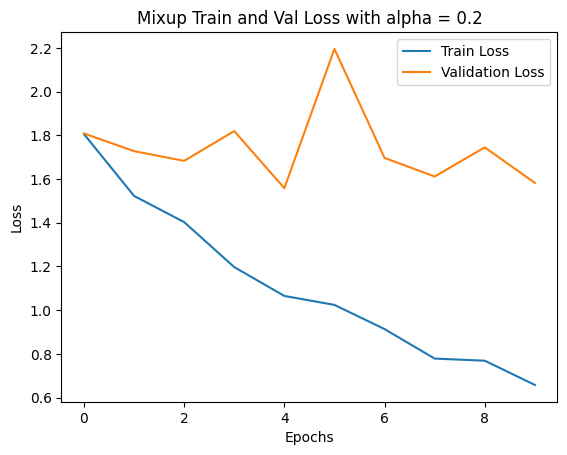

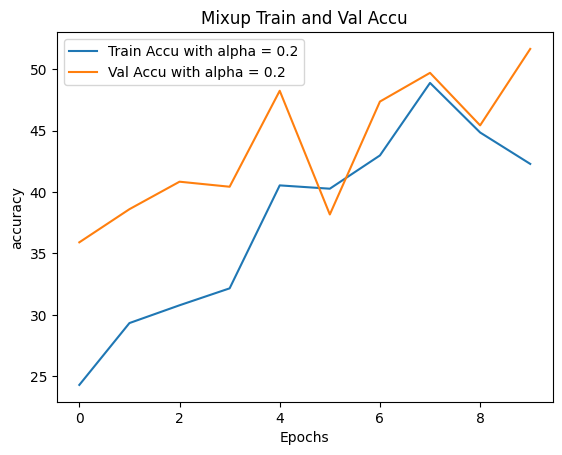

In [54]:
# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Mixup Train and Val Loss with alpha = 0.2')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accuracies, label='Train Accu with alpha = 0.2')
plt.plot(val_accuracies, label='Val Accu with alpha = 0.2' )
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Mixup Train and Val Accu')
plt.legend()
plt.show()



Run resNet18 with mixUp but Aplha = 0.4

In [55]:
# select resNet18 from pytorch
model = models.resnet18(pretrained=False)
# fully connected, 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
# use cross entropy as loss function
criterion = nn.CrossEntropyLoss()
# Adam to optimize the ggradient
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [56]:
# Train with alpha=0.4
train_losses04, train_accuracies04, val_losses04, val_accuracies04 = train_with_mixup(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    alpha=0.4,
    num_epochs=10,
    device=device
)


1 th epoch out of  10
Epoch 1, 	Train Loss: 1.8492, 	Train Acc: 24.18%, 	Val Loss: 1.7590, 	Val Acc: 36.70%

2 th epoch out of  10
Epoch 2, 	Train Loss: 1.5626, 	Train Acc: 26.42%, 	Val Loss: 1.5358, 	Val Acc: 44.60%

3 th epoch out of  10
Epoch 3, 	Train Loss: 1.4530, 	Train Acc: 33.59%, 	Val Loss: 1.4436, 	Val Acc: 49.22%

4 th epoch out of  10
Epoch 4, 	Train Loss: 1.3427, 	Train Acc: 32.81%, 	Val Loss: 1.3571, 	Val Acc: 51.82%

5 th epoch out of  10
Epoch 5, 	Train Loss: 1.1839, 	Train Acc: 37.71%, 	Val Loss: 1.4164, 	Val Acc: 52.20%

6 th epoch out of  10
Epoch 6, 	Train Loss: 1.1227, 	Train Acc: 39.26%, 	Val Loss: 1.4543, 	Val Acc: 51.42%

7 th epoch out of  10
Epoch 7, 	Train Loss: 1.0063, 	Train Acc: 36.56%, 	Val Loss: 1.4406, 	Val Acc: 51.78%

8 th epoch out of  10
Epoch 8, 	Train Loss: 0.9720, 	Train Acc: 35.74%, 	Val Loss: 1.3629, 	Val Acc: 55.58%

9 th epoch out of  10
Epoch 9, 	Train Loss: 0.8697, 	Train Acc: 47.67%, 	Val Loss: 1.4326, 	Val Acc: 54.16%

10 th epoch out of 

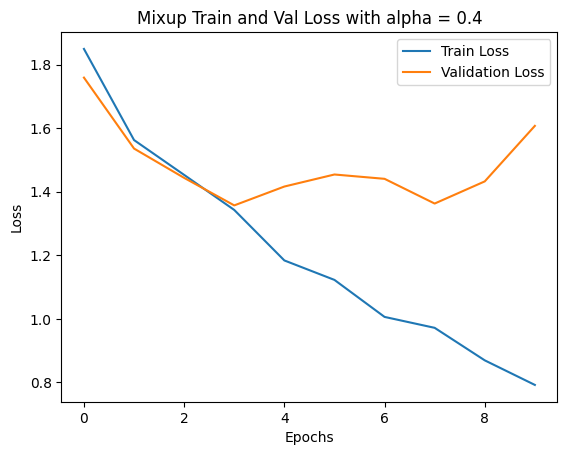

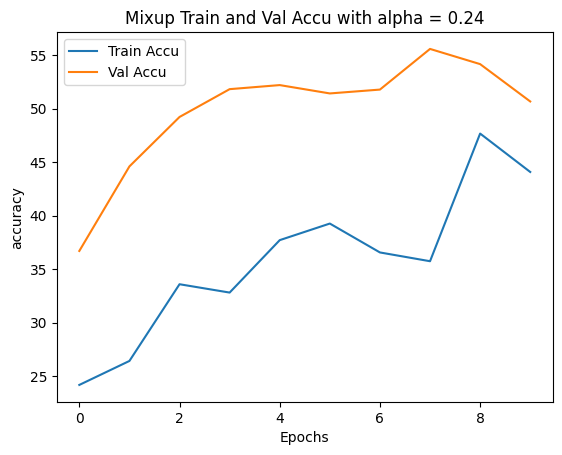

In [57]:
# Plot training and validation loss with alpha = 0.4
plt.plot(train_losses04, label='Train Loss')
plt.plot(val_losses04, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Mixup Train and Val Loss with alpha = 0.4')
plt.legend()
plt.show()

# Plot training and validation accuracy with alpha = 0.4
plt.plot(train_accuracies04, label='Train Accu')
plt.plot(val_accuracies04, label='Val Accu')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Mixup Train and Val Accu with alpha = 0.24')
plt.legend()
plt.show()


Plot both alpha = 0.2 and alpha = 0.4

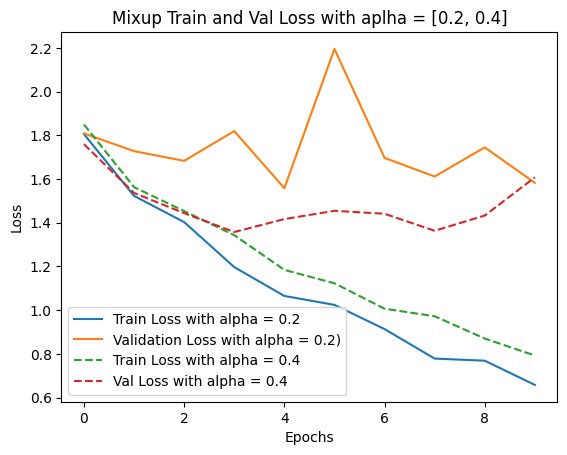

In [58]:
plt.plot(train_losses, label='Train Loss with alpha = 0.2')
plt.plot(val_losses, label='Validation Loss with alpha = 0.2)')

plt.plot(train_losses04, label='Train Loss with alpha = 0.4', linestyle='dashed')
plt.plot(val_losses04, label='Val Loss with alpha = 0.4', linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Mixup Train and Val Loss with aplha = [0.2, 0.4]')
plt.legend()
plt.show()


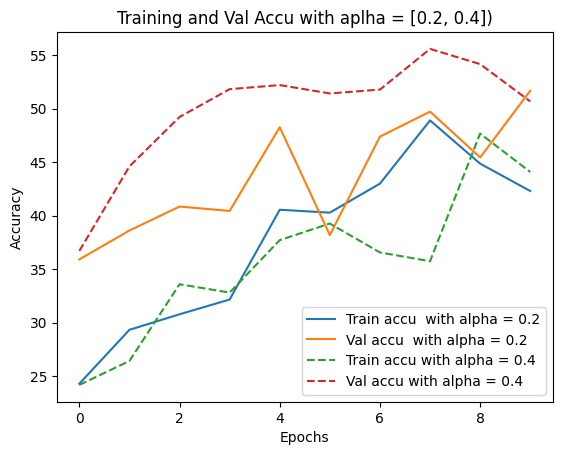

In [59]:
plt.plot(train_accuracies, label='Train accu  with alpha = 0.2')
plt.plot(val_accuracies, label='Val accu  with alpha = 0.2')

plt.plot(train_accuracies04, label='Train accu with alpha = 0.4', linestyle='dashed')
plt.plot(val_accuracies04, label='Val accu with alpha = 0.4', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Val Accu with aplha = [0.2, 0.4])')
plt.legend()
plt.show()


# Problem 3 Cutout

The implementation of Cutout https://juejin.cn/post/7115009909107720199

1. Cutout Augmentation Function

In [60]:
def cutout(image, cutout_size):
  channel, height, width = image.shape
  mask = np.ones((height, width))

  # select a sub-region from the image
  y_center = np.random.randint(0, height)
  x_center = np.random.randint(0, width)

  # mask boundaries
  y1 = max(0, y_center - cutout_size // 2)
  y2 = min(height, y_center + cutout_size // 2)
  x1 = max(0, x_center - cutout_size // 2)
  x2 = min(width, x_center + cutout_size // 2)

  # cut masks
  mask[y1:y2, x1:x2] = 0.0
  image = image * torch.tensor(mask, dtype=image.dtype, device=image.device)

  return image


2. setup Cutout Transform Class

In [61]:
class CutoutTransform:
  def __init__(self, cutout_size, probability=0.5):
    # initialize transformation
    self.cutout_size = cutout_size
    self.probability = probability

  def __call__(self, image):
    # apply the cutout
    if np.random.rand() < self.probability:
        return cutout(image, self.cutout_size)
    return image


3. Dataset Preparation with Cutout

In [62]:
# use torch's tensor
# permutation for batch, channels, height, width
x_train_tensor = torch.tensor(x_train_subset, dtype=torch.float32).permute(0, 3, 1, 2)  # [batch, channels, height, width]
y_train_tensor = torch.tensor(y_train_subset)

x_test_tensor = torch.tensor(test_images, dtype=torch.float32).permute(0, 3, 1, 2)  # [batch, channels, height, width]
y_test_tensor = torch.tensor(test_labels)

# create tensor datasets is compatie with pytorch expected format, combine both feature and target value in a row
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Apply Cutout whhile loading data
train_loader = DataLoader(train_dataset, batch_size=100, collate_fn=lambda batch: (
    torch.stack([CutoutTransform(cutout_size=16)(x) for x, label in batch]),
    torch.tensor([y for classes, y in batch])
))

test_loader = DataLoader(test_dataset, batch_size=100, collate_fn=lambda batch: (
    torch.stack([x for x, label in batch]),
    torch.tensor([y for classes, y in batch])
))


4. Model Definition

In [63]:
# select resNet18 from pytorch
model = models.resnet18(pretrained=False)
# fully connected, 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
# use cross entropy as loss function
criterion = nn.CrossEntropyLoss()
# Adam to optimize the ggradient
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

5. Training with cutout

In [64]:
train_losses, train_accuracies, val_losses, val_accuracies = train_baseline(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=10,
    device=device
)


1 th epoch out of  10
Epoch 1, 	Train Loss: 1.8814, 	Train Acc: 31.67%, 	Val Loss: 1.6327, 	Val Acc: 38.61%

2 th epoch out of  10
Epoch 2, 	Train Loss: 1.5740, 	Train Acc: 42.39%, 	Val Loss: 1.6317, 	Val Acc: 40.37%

3 th epoch out of  10
Epoch 3, 	Train Loss: 1.4451, 	Train Acc: 48.03%, 	Val Loss: 1.4814, 	Val Acc: 44.98%

4 th epoch out of  10
Epoch 4, 	Train Loss: 1.3219, 	Train Acc: 52.01%, 	Val Loss: 1.4282, 	Val Acc: 49.96%

5 th epoch out of  10
Epoch 5, 	Train Loss: 1.2169, 	Train Acc: 56.53%, 	Val Loss: 1.5335, 	Val Acc: 49.24%

6 th epoch out of  10
Epoch 6, 	Train Loss: 1.1231, 	Train Acc: 59.66%, 	Val Loss: 1.6338, 	Val Acc: 48.41%

7 th epoch out of  10
Epoch 7, 	Train Loss: 1.0495, 	Train Acc: 61.97%, 	Val Loss: 1.3471, 	Val Acc: 55.28%

8 th epoch out of  10
Epoch 8, 	Train Loss: 0.9642, 	Train Acc: 66.27%, 	Val Loss: 1.4140, 	Val Acc: 53.79%

9 th epoch out of  10
Epoch 9, 	Train Loss: 0.8798, 	Train Acc: 69.29%, 	Val Loss: 1.3059, 	Val Acc: 56.50%

10 th epoch out of 

6. Visualize Cutout-Augmented Images

In [65]:
# # Visualize Cutout on training images
# def visualize_cutout(loader):
#     for images, labels in loader:
#         fig, axes = plt.subplots(1, 5)
#         for i in range(5):
#             image = images[i].permute(1, 2, 0)
#             axes[i].imshow(image)
#         plt.show()
#         break

# visualize_cutout(train_loader)


7. PLot learning curves

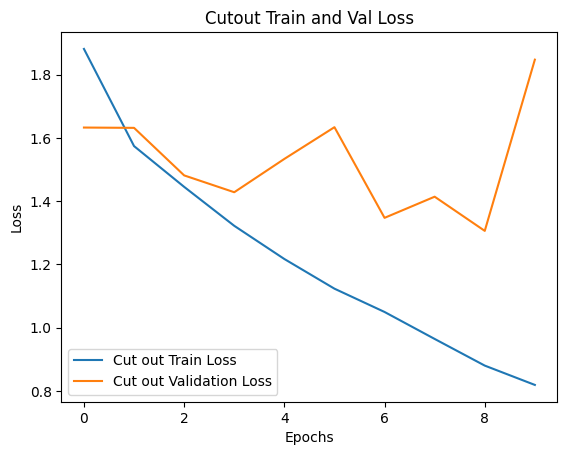

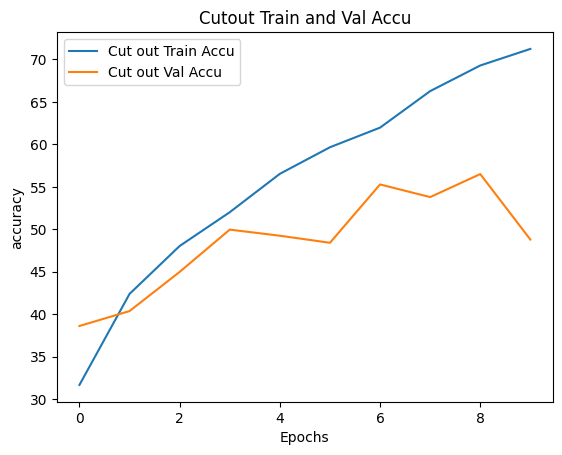

In [66]:
# Plot training and validation loss
plt.plot(train_losses, label='Cut out Train Loss')
plt.plot(val_losses, label='Cut out Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Cutout Train and Val Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accuracies, label='Cut out Train Accu')
plt.plot(val_accuracies, label='Cut out Val Accu')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Cutout Train and Val Accu')
plt.legend()
plt.show()

# Problem 4 standard augumentation

1. Define the Standard Augmentation Function https://www.youtube.com/watch?v=mTVf7BN7S8w&t=1571s


In [67]:
def standard_augmentation(image, max_shift=4):
    channel, height, width = image.shape

    # select a sub-region to shift
    k1 = np.random.randint(-max_shift, max_shift + 1)  # shifting vertically
    k2 = np.random.randint(-max_shift, max_shift + 1)  # shifting horinzaontaly

    # padding
    padded_image = torch.zeros_like(image).to(image.device)
    y_start = max(0, k1)
    y_end = height + min(0, k1)
    x_start = max(0, k2)
    x_end = width + min(0, k2)
    padded_image[:, y_start:y_end, x_start:x_end] = image[:, max(0, -k1):height - max(0, k1), max(0, -k2):width - max(0, k2)]

    # flipping image with a 50% probability
    if np.random.rand() < 0.5:
        padded_image = torch.flip(padded_image, dims=[2])

    return padded_image


2. set up the standard augmentaion transform, max_shift is the maximum shift of pixels, and with probality of 50% to flip the image

In [68]:
class StandardAugmentationTransform:
    def __init__(self, max_shift=4, probability=0.5):
        self.max_shift = max_shift
        self.probability = probability

    def __call__(self, image):
        return standard_augmentation(image, max_shift=self.max_shift)


3. Update the DataLoader for Standard Augmentation

In [69]:
# DataLoaders for standard augmentation
train_loader = DataLoader(train_dataset, batch_size=100, collate_fn=lambda batch: (
    torch.stack([StandardAugmentationTransform(max_shift=4)(x) for x, label in batch]),
    torch.tensor([y for classes, y in batch])
))

test_loader = DataLoader(test_dataset, batch_size=100, collate_fn=lambda batch: (
    torch.stack([x for x, label in batch]),
    torch.tensor([y for classes, y in batch])
))


Reset the model and optimizer for training

In [70]:
# select resNet18 from pytorch
model = models.resnet18(pretrained=False)
# fully connected, 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
# use cross entropy as loss function
criterion = nn.CrossEntropyLoss()
# Adam to optimize the ggradient
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

4. Train the Model with Standard Augmentation

In [71]:


# Train the model with Standard Augmentation
train_losses, train_accuracies, val_losses, val_accuracies = train_baseline(
    model,
    train_loader,  # Data loader with standard augmentation
    test_loader,   # Standard test data loader
    criterion,
    optimizer,
    num_epochs=10,
    device=device
)


1 th epoch out of  10
Epoch 1, 	Train Loss: 1.8725, 	Train Acc: 31.83%, 	Val Loss: 1.9464, 	Val Acc: 31.15%

2 th epoch out of  10
Epoch 2, 	Train Loss: 1.5907, 	Train Acc: 42.01%, 	Val Loss: 1.7652, 	Val Acc: 37.83%

3 th epoch out of  10
Epoch 3, 	Train Loss: 1.4900, 	Train Acc: 45.99%, 	Val Loss: 1.6849, 	Val Acc: 40.58%

4 th epoch out of  10
Epoch 4, 	Train Loss: 1.3974, 	Train Acc: 48.98%, 	Val Loss: 1.5428, 	Val Acc: 47.02%

5 th epoch out of  10
Epoch 5, 	Train Loss: 1.3135, 	Train Acc: 52.53%, 	Val Loss: 1.6884, 	Val Acc: 43.82%

6 th epoch out of  10
Epoch 6, 	Train Loss: 1.2444, 	Train Acc: 55.28%, 	Val Loss: 1.5535, 	Val Acc: 46.71%

7 th epoch out of  10
Epoch 7, 	Train Loss: 1.1842, 	Train Acc: 57.68%, 	Val Loss: 1.9896, 	Val Acc: 41.95%

8 th epoch out of  10
Epoch 8, 	Train Loss: 1.1262, 	Train Acc: 59.11%, 	Val Loss: 1.3640, 	Val Acc: 52.77%

9 th epoch out of  10
Epoch 9, 	Train Loss: 1.0735, 	Train Acc: 61.39%, 	Val Loss: 1.4733, 	Val Acc: 50.53%

10 th epoch out of 

5. Visualize Augmented Images

In [72]:

# # Visualize standard augmentation on training images
# def visualize_standard_augmentation(loader):
#     for images, _ in loader:
#         fig, axes = plt.subplots(1, 5, figsize=(15, 5))
#         for i in range(5):
#             image = images[i].permute(1, 2, 0).numpy()  # Convert to HWC for display
#             axes[i].imshow(image)
#             axes[i].axis('off')
#         plt.show()
#         break

# visualize_standard_augmentation(train_loader)


Plot Learning curve

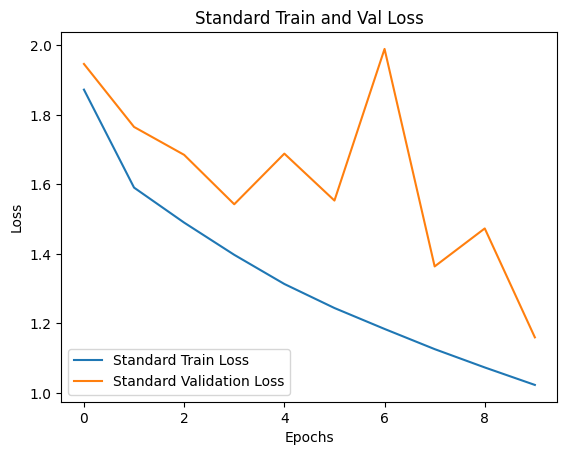

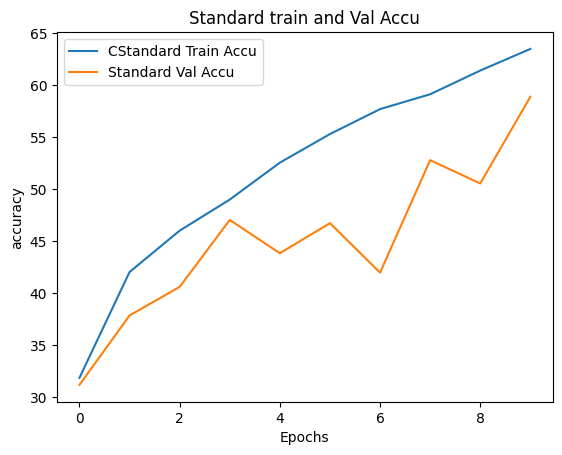

In [73]:
# Plot training and validation loss
plt.plot(train_losses, label='Standard Train Loss')
plt.plot(val_losses, label='Standard Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Standard Train and Val Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(train_accuracies, label='CStandard Train Accu')
plt.plot(val_accuracies, label='Standard Val Accu')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Standard train and Val Accu')
plt.legend()
plt.show()

# Problem 5

Combined Augmentation Pipeline
We will:

1. Apply Standard Augmentation (shifting and flipping).
2. Apply Cutout.
3. Use Mixup as the final augmentation during training.
Standard + Cutout Augmentation Transform

In [74]:
class CombinedTransform:
  def __init__(self, cutout_size=16, max_shift=4, mixup_alpha=0.2, mixup_prob=0.5):
    self.cutout_size = cutout_size #cutout_size: Size of the Cutout sub-region
    self.max_shift = max_shift# shift for standard.
    self.mixup_alpha = mixup_alpha#Alpha for Mixup augmentation, choose a = 0.2 this case.
    self.mixup_prob = mixup_prob# Mixup.

  def standard_and_cutout(self, image):
    # Apply standard + cutout augm to a image
    image = standard_augmentation(image, max_shift=self.max_shift)
    image = cutout(image, cutout_size=self.cutout_size)
    return image

  def __call__(self, images, labels):
    # Apply standard + cutout augm to all images
    augmented_images = torch.stack([self.standard_and_cutout(img) for img in images])

    # Apply Mixup
    if np.random.rand() < self.mixup_prob:
      lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
      indices = torch.randperm(augmented_images.size(0))
      mixed_images = lam * augmented_images + (1 - lam) * augmented_images[indices, :]
      mixed_labels = lam * labels + (1 - lam) * labels[indices]
      return mixed_images, mixed_labels

    return augmented_images, labels


Dataset Loader with CombinedAugmentation

In [75]:
# # Convert scalar labels to one-hot encoding(to_one_hot defined in mixup)
y_train_one_hot = to_one_hot(torch.tensor(y_train_subset, dtype=torch.long))
y_test_one_hot = to_one_hot(torch.tensor(test_labels, dtype=torch.long))

# set up transformer with CombinedTransform
combined_transform = CombinedTransform(cutout_size=16, max_shift=4, mixup_alpha=0.2)  # Use a =0.2 based on observation

# DataLoader with CombinedTransform
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, collate_fn=lambda batch: combined_transform(
  torch.stack([x for x, label in batch]),
  torch.stack([to_one_hot(y, classes=10) for label, y in batch])
))

test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, collate_fn=lambda batch: (
  torch.stack([x for x, label in batch]),
  torch.stack([to_one_hot(y, classes=10) for label, y in batch])
))



Training Function

In [76]:
def train_combined(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cuda'):

  model.to(device)

  # save learning records
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for epoch in range(num_epochs):
    print(epoch + 1,"th epoch out of ", num_epochs)
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(train_loader):
      inputs, targets = inputs.to(device), targets.to(device)

      # forward pass
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, torch.argmax(targets, dim=1))  # Use scalar labels for CrossEntropyLoss

      # backward pass and Adam optimizing
      loss.backward()
      optimizer.step()

      # record loss
      running_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      total += targets.size(0)
      correct += (predicted == torch.argmax(targets, dim=1)).sum().item()

    # track progress
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # evaluate on validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
      for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(targets, dim=1))  # Use scalar labels for CrossEntropyLoss

        # record loss
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_total += targets.size(0)
        val_correct += (predicted == torch.argmax(targets, dim=1)).sum().item()

    # track progress
    val_loss /= len(test_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

  return train_losses, train_accuracies, val_losses, val_accuracies


reset the model

In [77]:
# select resNet18 from pytorch
model = models.resnet18(pretrained=False)
# fully connected, 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
# use cross entropy as loss function
criterion = nn.CrossEntropyLoss()
# Adam to optimize the ggradient
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Train the Model with Combined Augmentation

In [78]:
train_losses, train_accuracies, val_losses, val_accuracies = train_combined(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=10,
    device=device
)


1 th epoch out of  10
Epoch 1, Train Loss: 2.0731, Train Acc: 24.68%, Val Loss: 2.1605, Val Acc: 25.42%
2 th epoch out of  10
Epoch 2, Train Loss: 1.8423, Train Acc: 31.76%, Val Loss: 1.7410, Val Acc: 36.45%
3 th epoch out of  10
Epoch 3, Train Loss: 1.7583, Train Acc: 35.08%, Val Loss: 1.6155, Val Acc: 40.94%
4 th epoch out of  10
Epoch 4, Train Loss: 1.6975, Train Acc: 38.57%, Val Loss: 1.9291, Val Acc: 37.72%
5 th epoch out of  10
Epoch 5, Train Loss: 1.6532, Train Acc: 40.99%, Val Loss: 1.5227, Val Acc: 44.98%
6 th epoch out of  10
Epoch 6, Train Loss: 1.6077, Train Acc: 41.71%, Val Loss: 1.4772, Val Acc: 47.01%
7 th epoch out of  10
Epoch 7, Train Loss: 1.5437, Train Acc: 43.71%, Val Loss: 1.5724, Val Acc: 45.24%
8 th epoch out of  10
Epoch 8, Train Loss: 1.4931, Train Acc: 45.77%, Val Loss: 1.6038, Val Acc: 44.22%
9 th epoch out of  10
Epoch 9, Train Loss: 1.4574, Train Acc: 47.82%, Val Loss: 2.8285, Val Acc: 31.03%
10 th epoch out of  10
Epoch 10, Train Loss: 1.4647, Train Acc: 

Visualize Results
To analyze the results.
Plot Loss and accuracy for both training and validation


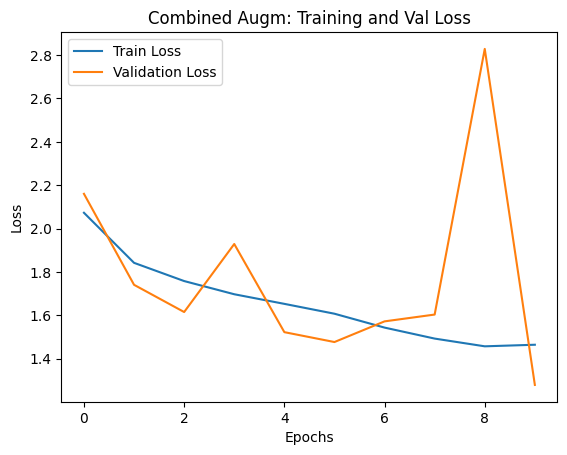

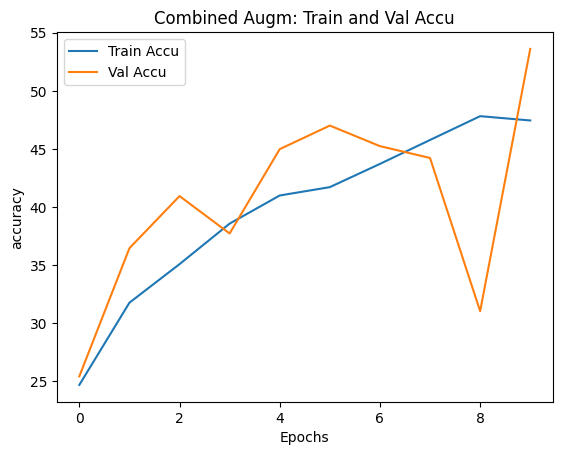

In [79]:
# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Combined Augm: Training and Val Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy)
plt.plot(train_accuracies, label='Train Accu')
plt.plot(val_accuracies, label='Val Accu')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Combined Augm: Train and Val Accu')
plt.legend()
plt.show()


# Some Additional hyper parameter tunning

In [80]:
# # Convert scalar labels to one-hot encoding(to_one_hot defined in mixup)
y_train_one_hot = to_one_hot(torch.tensor(y_train_subset, dtype=torch.long))
y_test_one_hot = to_one_hot(torch.tensor(test_labels, dtype=torch.long))

# set up transformer with CombinedTransform
combined_transform = CombinedTransform(cutout_size=9, max_shift=2, mixup_alpha=0.3)  # Use a =0.3 to mixup, shift size = 2, and smaller mask-size

# DataLoader with CombinedTransform
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, collate_fn=lambda batch: combined_transform(
  torch.stack([x for x, label in batch]),
  torch.stack([to_one_hot(y, classes=10) for label, y in batch])
))

test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, collate_fn=lambda batch: (
  torch.stack([x for x, label in batch]),
  torch.stack([to_one_hot(y, classes=10) for label, y in batch])
))



In [81]:
# select resNet18 from pytorch
model = models.resnet18(pretrained=False)
# fully connected, 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 has 10 classes
# use cross entropy as loss function
criterion = nn.CrossEntropyLoss()
# Adam to optimize the ggradient
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [87]:
train_losses, train_accuracies, val_losses, val_accuracies = train_combined(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs=20,
    device=device
)

1 th epoch out of  20
Epoch 1, Train Loss: 0.7128, Train Acc: 75.97%, Val Loss: 1.0965, Val Acc: 64.81%
2 th epoch out of  20
Epoch 2, Train Loss: 0.7062, Train Acc: 75.85%, Val Loss: 1.0873, Val Acc: 64.77%
3 th epoch out of  20
Epoch 3, Train Loss: 0.6613, Train Acc: 77.31%, Val Loss: 1.2888, Val Acc: 61.37%
4 th epoch out of  20
Epoch 4, Train Loss: 0.6248, Train Acc: 78.63%, Val Loss: 1.1863, Val Acc: 62.87%
5 th epoch out of  20
Epoch 5, Train Loss: 0.6065, Train Acc: 79.02%, Val Loss: 0.9543, Val Acc: 70.15%
6 th epoch out of  20
Epoch 6, Train Loss: 0.6246, Train Acc: 79.25%, Val Loss: 1.5036, Val Acc: 56.45%
7 th epoch out of  20
Epoch 7, Train Loss: 0.6217, Train Acc: 78.72%, Val Loss: 0.9700, Val Acc: 69.18%
8 th epoch out of  20
Epoch 8, Train Loss: 0.5557, Train Acc: 80.90%, Val Loss: 1.2234, Val Acc: 63.16%
9 th epoch out of  20
Epoch 9, Train Loss: 0.6343, Train Acc: 78.91%, Val Loss: 1.1736, Val Acc: 62.98%
10 th epoch out of  20
Epoch 10, Train Loss: 0.5384, Train Acc: 

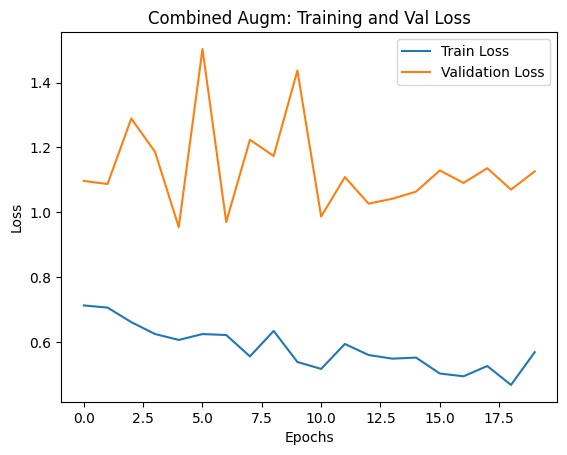

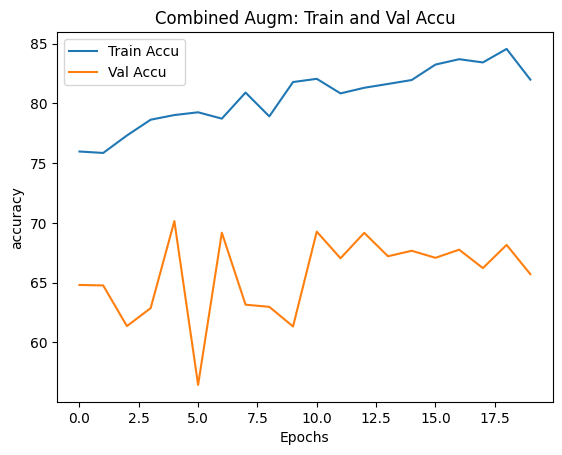

In [88]:
# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Combined Augm: Training and Val Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy)
plt.plot(train_accuracies, label='Train Accu')
plt.plot(val_accuracies, label='Val Accu')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Combined Augm: Train and Val Accu')
plt.legend()
plt.show()
